In [ ]:
'''
In this notebook i will select data from a specific area and time period. Lets use the data from 2015 to 2025 and 
the area of 18N to 22N and 91W to 86W. For that time period, i want to know how correlated is the temperature in that area 
with another grid points, Also i want to know how correlated is the precipitation in that area with another grid points.
Finally i want to know how is the covariance between temperature and precipitation in that area.

Daniela Risaro
July 2025
'''

import os 
import numpy as np 
import xarray as xr 
import pandas as pd 


## select data from 2015 to 2025 and 18N to 22N and 91W to 86W.

data_dir = "../data/raw/"
output_dir = "../data/processed/"

os.makedirs(output_dir, exist_ok=True)

files_temperature = sorted([file for file in os.listdir(data_dir) if file.endswith(".nc") and "tmax" in file])
files_precipitation = sorted([file for file in os.listdir(data_dir) if file.endswith(".nc") and "precipitation" in file])

wanted_years = list(range(2015, 2026))

lat_min, lat_max = 18, 22 
lon_min, lon_max = -91, -86  

temp_datasets = [xr.open_dataset(data_dir + f) for f in files_temperature 
                if int(f.split("_")[-1].split(".")[0]) in wanted_years]
temperature = xr.concat(temp_datasets, dim="valid_time")
temperature = temperature["t2m"] - 273.15

precip_datasets = [xr.open_dataset(data_dir + f) for f in files_precipitation 
                  if int(f.split("_")[-1].split(".")[0]) in wanted_years]
precipitation = xr.concat(precip_datasets, dim="valid_time")
precipitation = precipitation["tp"]  

temp_region = temperature.sel(
    latitude=slice(lat_max, lat_min),
    longitude=slice(lon_min, lon_max),
    valid_time=slice("2015-01-01", "2025-06-30")
)

precip_region = precipitation.sel(
    latitude=slice(lat_max, lat_min),
    longitude=slice(lon_min, lon_max), 
    valid_time=slice("2015-01-01", "2025-06-30")
)



In [ ]:
import matplotlib.pyplot as plt

ref_lat = 20.645092
ref_lon = -87.085771

ref_temp = temp_region.sel(latitude=ref_lat, longitude=ref_lon, method='nearest')
ref_precip = precip_region.sel(latitude=ref_lat, longitude=ref_lon, method='nearest')

print(f"Actual grid point coordinates used:")
print(f"Latitude: {float(ref_temp.latitude.values):.3f}°N")
print(f"Longitude: {float(ref_temp.longitude.values):.3f}°W")

temp_correlations = xr.corr(ref_temp, temp_region, dim='valid_time')

#precip_correlations = xr.corr(ref_precip, precip_region, dim='valid_time')



Actual grid point coordinates used:
Latitude: 20.750°N
Longitude: -87.000°W


In [ ]:
from scipy import stats

precip_correlations = xr.zeros_like(precip_region.isel(valid_time=0))

ref_precip_values = ref_precip.values

for lat in precip_region.latitude:
    for lon in precip_region.longitude:
        target_precip = precip_region.sel(latitude=lat, longitude=lon)
        target_precip_values = target_precip.values
        
        rho, _ = stats.spearmanr(ref_precip_values, target_precip_values, nan_policy='omit')
        
        precip_correlations.loc[dict(latitude=lat, longitude=lon)] = rho

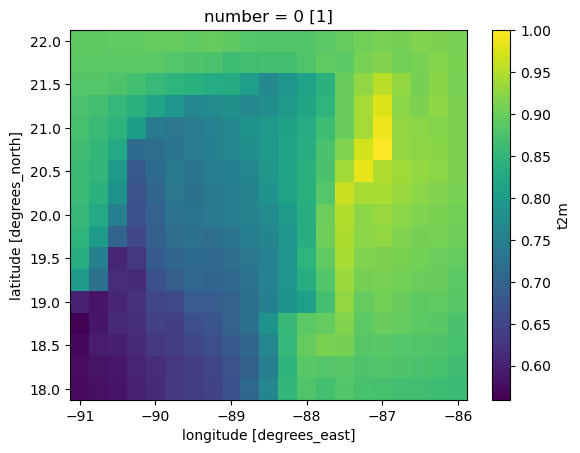

In [49]:
temp_correlations.plot()

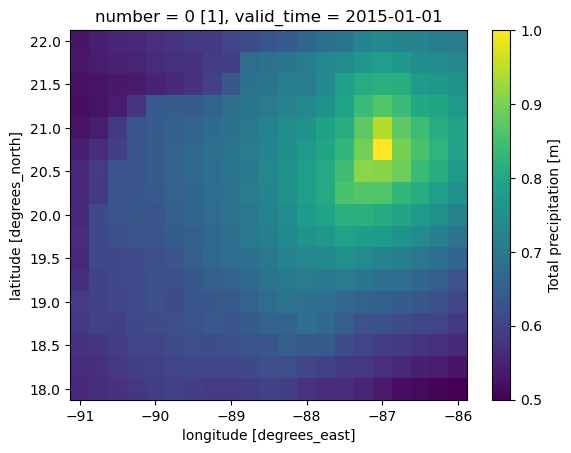

In [41]:
precip_correlations.plot()

In [39]:
import pandas as pd

# Create a DataFrame with the time series at the reference point
df = pd.DataFrame({
    'date': ref_temp.valid_time.values,
    'temperature': ref_temp.values,
    'precipitation': ref_precip.values
})

# Sort by date just to be sure
df = df.sort_values('date')

# Export to CSV
output_path = '../outputs/tulum_temp_precip_timeseries.csv'
df.to_csv(output_path, index=False)

print(f"Data exported to: {output_path}")
print("\nFirst few rows of the data:")
print(df.head())

Data exported to: ../outputs/tulum_temp_precip_timeseries.csv

First few rows of the data:
        date  temperature  precipitation
0 2015-01-01    27.231354       0.000147
1 2015-01-02    27.373688       0.000154
2 2015-01-03    27.882965       0.000223
3 2015-01-04    27.771881       0.000277
4 2015-01-05    27.114166       0.000121


<Axes: >

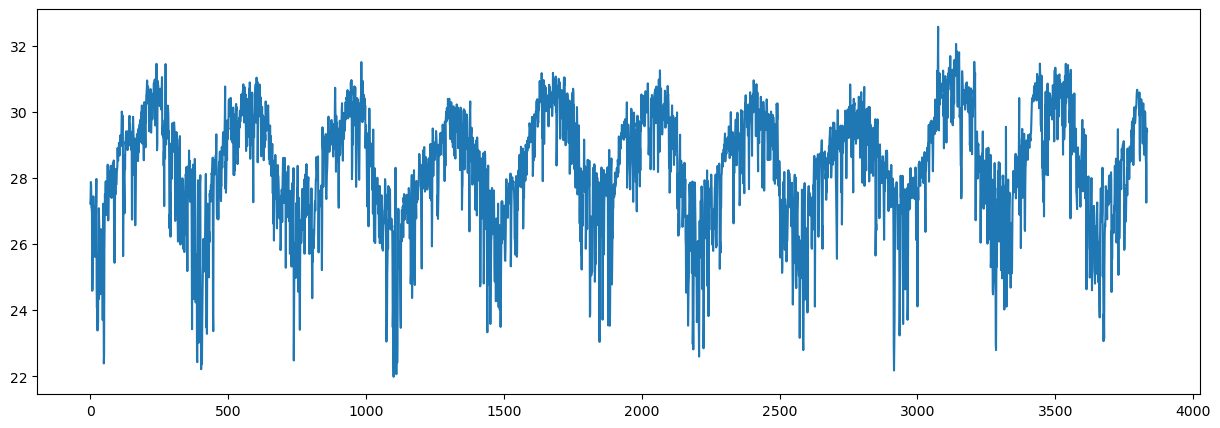

In [47]:
df['temperature'].plot(figsize=(15, 5))

<Axes: >

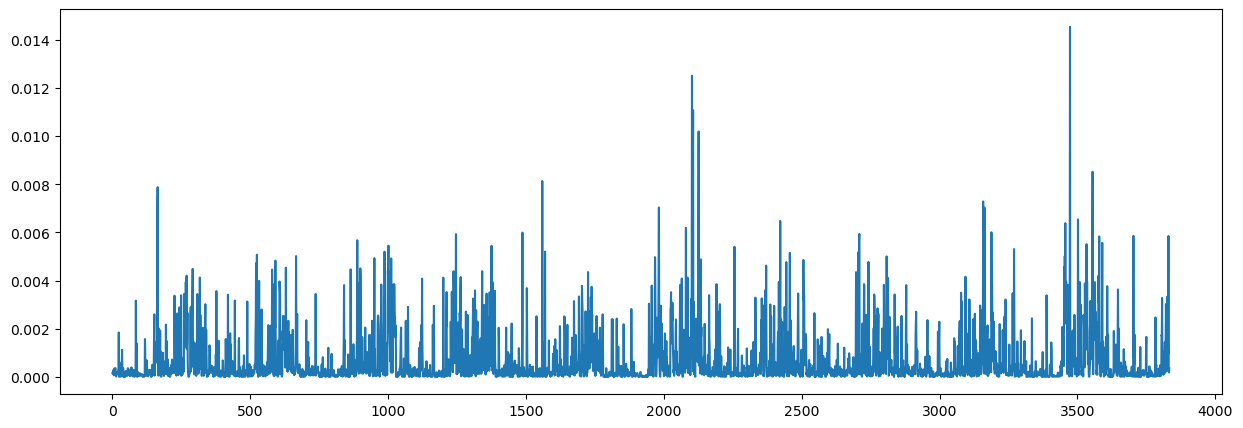

In [46]:
df['precipitation'].plot(figsize=(15, 5))

In [ ]:
df_